In [117]:
import argparse
import numpy as np
from plot_utils import *

import awkward as ak
from pathlib import Path
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import mplhep as hep
import json

# hep.style.use("CMS")
plt.style.use(hep.style.CMS)

In [86]:
def delta_phi(arr1_phi , arr2_phi , mask = None):
    del_phi = arr1_phi - arr2_phi

    # Handling phi wraparound
    del_phi = ak.where(del_phi > np.pi, del_phi - 2*np.pi, del_phi)
    del_phi = ak.where(del_phi < -np.pi, del_phi + 2*np.pi, del_phi)

    if mask is not None:
        return del_phi[mask]
    else:
        return del_phi

def delta_r(arr1_eta , arr1_phi, arr2_eta, arr2_phi, mask = None):

    del_eta = arr1_eta - arr2_eta
    del_phi = delta_phi(arr1_phi , arr2_phi)
    
    del_r = np.sqrt(del_eta**2 + del_phi**2)
    if mask is not None:
        return del_r[mask]
    else:
        return del_r

def mass_invariant(pt1 , pt2 , eta1 , eta2 , phi1 , phi2 , mask = None):
    
    del_eta = eta1 - eta2
    del_phi = delta_phi(phi1 , phi2)
    m_inv = np.sqrt(2*pt1*pt2*(np.cosh(del_eta)-np.cos(del_phi)))
    if mask is not None:
        return m_inv[mask]
    else:
        return m_inv

def vectorize(pt , eta , phi , _4vector = False, mask = None):
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = pt*np.sinh(eta)
    E = pt*np.cosh(eta)
    
    if mask is not None:
        px = px[mask]
        py = py[mask]
        pz = pz[mask]
        E  = E[mask]
        
    if _4vector:
        return ak.Array([E , px , py, pz])
    else:
        return ak.Array([px , py, pz])

## Merged

In [65]:
MC = {}
processes = ["vh_M-70", "vbf_M-70", "tth_M-70", "ggh_M-70"]   #["vh_M-70", "GluGluHtoGG_M-70", "vbf_M-70", "ttHtoGG_M-70"]
for i, proc in enumerate(processes):
    MC[f'{proc}'] = {}
    MC[f'{proc}'] = ak.from_parquet(f'NTuples/merged/{proc}_postEE/NOTAG_merged.parquet')

In [6]:
MC['vh_M-70'].fields

['pt',
 'eta',
 'phi',
 'mass',
 'charge',
 'rapidity',
 'jet1_pt',
 'jet1_eta',
 'jet1_phi',
 'jet1_mass',
 'jet1_charge',
 'jet1_btagPNetB',
 'jet1_btagDeepFlavB',
 'jet1_btagDeepFlav_CvB',
 'jet1_btagDeepFlav_CvL',
 'jet1_btagDeepFlav_QG',
 'jet1_neHEF',
 'jet1_neEmEF',
 'jet1_muEF',
 'jet1_chEmEF',
 'jet1_jetId',
 'jet1_chMultiplicity',
 'jet1_neMultiplicity',
 'jet1_chHEF',
 'jet2_pt',
 'jet2_eta',
 'jet2_phi',
 'jet2_mass',
 'jet2_charge',
 'jet2_btagPNetB',
 'jet2_btagDeepFlavB',
 'jet2_btagDeepFlav_CvB',
 'jet2_btagDeepFlav_CvL',
 'jet2_btagDeepFlav_QG',
 'jet2_neHEF',
 'jet2_neEmEF',
 'jet2_muEF',
 'jet2_chEmEF',
 'jet2_jetId',
 'jet2_chMultiplicity',
 'jet2_neMultiplicity',
 'jet2_chHEF',
 'jet3_pt',
 'jet3_eta',
 'jet3_phi',
 'jet3_mass',
 'jet3_charge',
 'jet3_btagPNetB',
 'jet3_btagDeepFlavB',
 'jet3_btagDeepFlav_CvB',
 'jet3_btagDeepFlav_CvL',
 'jet3_btagDeepFlav_QG',
 'jet3_neHEF',
 'jet3_neEmEF',
 'jet3_muEF',
 'jet3_chEmEF',
 'jet3_jetId',
 'jet3_chMultiplicity',
 'jet

In [6]:
elec , mu , jets = {}, {}, {}
events_num =  np.array([83229, 93217, 107298, 96535])
for i , proc in enumerate(["vh_M-70", "vbf_M-70", "tth_M-70", "ggh_M-70"]):
    elec[proc] = MC[proc].n_electrons
    mu[proc] = MC[proc].n_muons
    jets[proc] = MC[proc].n_jets
    events_num[i] = len(elec[proc])

In [16]:
for i , proc in enumerate(["vh_M-70", "GluGluHtoGG_M-70", "vbf_M-70", "ttHtoGG_M-70"]):
    print(proc , ': ', ak.sum(  (elec[proc] > 0 ) | (mu[proc] > 0) )) #/events_num[i]
    # print(proc , ': ', 100*ak.sum(  ((elec[proc] == 0 ) & (mu[proc] == 0))   &  (jets[proc]>0)  )/events_num[i])
    # print(proc , ': ', 100*ak.sum(   (   ((elec[proc] == 0) & (mu[proc] == 1)) | ((elec[proc] == 1) & (mu[proc] == 0))   )   &  (jets[proc]==1)  )/events_num[i])

vh_M-70 :  13046
GluGluHtoGG_M-70 :  147
vbf_M-70 :  463
ttHtoGG_M-70 :  33220


In [8]:
# 0.0614
# M	0.3196
# T	0.73

In [9]:
jets_not_btagged = {}
lead_jet_not_btagged = {}
for i , proc in enumerate(processes):
    # mask = np.array([MC[proc].jet1_btagDeepFlavB , MC[proc].jet2_btagDeepFlavB , MC[proc].jet3_btagDeepFlavB , MC[proc].jet4_btagDeepFlavB , MC[proc].jet5_btagDeepFlavB])
    # jets_not_btagged[proc] = ak.sum(((0.3196 > mask) & (mask > -1)), axis= 0)
    lead_jet_not_btagged[proc] = ((MC[proc].jet1_btagDeepFlavB > -1 ) & (MC[proc].jet1_btagDeepFlavB < 0.0614))

In [10]:
# At least one lepton and if there is a jet then the lead jet is not b-tagged
for i , proc in enumerate(processes):
    print(proc , ': ', ak.sum(  ((elec[proc] > 0 ) | (mu[proc] > 0))   &  ((jets[proc] == 0) | (lead_jet_not_btagged[proc] == True))  ))
    # print(proc , ': ', 100*ak.sum(  ((elec[proc] == 0 ) & (mu[proc] == 0))   &  (jets_not_btagged[proc] > 0)  )/events_num[i])
    # print(proc , ': ', 100*ak.sum(   (   ((elec[proc] == 0) & (mu[proc] == 1)) | ((elec[proc] == 1) & (mu[proc] == 0))   )   &  (jets[proc]==0)  )/events_num[i])

vh_M-70 :  11283
vbf_M-70 :  381
tth_M-70 :  15139
ggh_M-70 :  122


In [11]:
# no leptons and 50 GeV PUPPI MET
for i , proc in enumerate(processes):
    print(proc , ': ', ak.sum(  ((elec[proc] == 0 ) & (mu[proc] == 0))   &  (MC[proc].PuppiMET_pt > 50.0) & (lead_jet_not_btagged[proc] == True)   ))  #/events_num[i]
    # print(proc , ': ', 100*ak.sum(  ((elec[proc] == 0 ) & (mu[proc] == 0))   &  (jets_not_btagged[proc] > 0)  )/events_num[i]) 
    

vh_M-70 :  9832
vbf_M-70 :  10074
tth_M-70 :  15642
ggh_M-70 :  5181


In [11]:
jets_not_btagged

{'vh_M-70': <Array [2, 3, 1, 0, 1, 2, 0, 2, ..., 2, 1, 2, 2, 1, 0, 3] type='83229 * int64'>,
 'GluGluHtoGG_M-70': <Array [1, 2, 0, 1, 2, 1, 1, 0, ..., 1, 2, 3, 3, 2, 0, 2] type='93217 * int64'>,
 'vbf_M-70': <Array [1, 3, 3, 3, 1, 1, 2, 2, ..., 4, 1, 1, 3, 2, 3, 1] type='107298 * int64'>,
 'ttHtoGG_M-70': <Array [2, 5, 2, 4, 3, 4, 4, 4, ..., 3, 4, 4, 1, 1, 4, 4] type='96535 * int64'>}

### Plots

In [101]:
# photon variables
photon_pt , photon_eta , photon_phi = {} , {} , {}
# m_gg = {}
photon_cos_del_phi = {}

# atleast 1 lepton
lep_pt , lep_eta , lep_phi = {} , {} , {}
delta_r_lead_lead_lep , delta_r_sublead_lead_lep = {} , {}

# atleast 2 leptons
delta_r_lead_sublead_lep , delta_r_sublead_sublead_lep = {} , {}
m_ll = {}
lepton_cos_del_phi = {}
theta_photons_leptons = {}

# atleast 1 jet
Njet , jet_pt , jet_btagDeepFlavB = {} , {} , {}

# PuppiMET
MET_pt , MET_sumEt = {} , {}


for proc in processes:
    # PHOTON variables
    photon_pt[proc] = ak.Array(np.stack([MC[proc].lead_pt, MC[proc].sublead_pt], axis =-1 ))
    photon_eta[proc] = ak.Array(np.stack([MC[proc].lead_eta, MC[proc].sublead_eta], axis =-1 ))
    photon_phi[proc] = ak.Array(np.stack([MC[proc].lead_phi, MC[proc].sublead_phi], axis =-1 ))

    # Invariant mass and Cos(∆Φ)
    # m_gg[proc] = MC[proc].mass #mass_invariant(photon_pt[proc][:, 0] , photon_pt[proc][:, 1] , photon_eta[proc][:, 0] , photon_eta[proc][:, 1] , photon_phi[proc][:, 0] , photon_phi[proc][:, 1] )
    photon_cos_del_phi[proc] = np.cos(delta_phi(photon_phi[proc][:, 0] , photon_phi[proc][:, 1]))

    # lEPTONS
    lep_pt[proc] = ak.Array(np.stack([MC[proc].muon1_pt, MC[proc].muon2_pt, MC[proc].electron1_pt, MC[proc].electron2_pt], axis = -1))
    sort_indices = ak.argsort(lep_pt[proc] , ascending = False)

    lep_pt[proc] = lep_pt[proc][sort_indices][:, :2]
    lep_eta[proc] = ak.Array(np.stack([MC[proc].muon1_eta, MC[proc].muon2_eta, MC[proc].electron1_eta, MC[proc].electron2_eta], axis = -1))[sort_indices][: , :2]
    lep_phi[proc] = ak.Array(np.stack([MC[proc].muon1_phi, MC[proc].muon2_phi, MC[proc].electron1_phi, MC[proc].electron2_phi], axis = -1))[sort_indices][: , :2]

    # delta R Photons and lead lepton
    delta_r_lead_lead_lep[proc] = delta_r(photon_eta[proc][:, 0] , photon_phi[proc][:, 0] , lep_eta[proc][:,0] , lep_phi[proc][:,0] , lep_pt[proc][:,0] > -1 )
    delta_r_sublead_lead_lep[proc] = delta_r(photon_eta[proc][:, 1] , photon_phi[proc][:, 1] , lep_eta[proc][:,0] , lep_phi[proc][:,0] , lep_pt[proc][:,0] > -1 )

    # At least 2 leptons
    mask_2_lep = lep_pt[proc][: , 1] > -1 
    # delta R Photons and sublead lepton
    delta_r_lead_sublead_lep[proc] = delta_r(photon_eta[proc][:, 0] , photon_phi[proc][:, 0] , lep_eta[proc][:,1] , lep_phi[proc][:,1] , mask_2_lep)
    delta_r_sublead_sublead_lep[proc] = delta_r(photon_eta[proc][:, 1] , photon_phi[proc][:, 1] , lep_eta[proc][:,1] , lep_phi[proc][:,1] , mask_2_lep )

    # Invariant mass and Cos(∆Φ)
    m_ll[proc] = mass_invariant(lep_pt[proc][:, 0] , lep_pt[proc][:, 1] , lep_eta[proc][:, 0] , lep_eta[proc][:, 1] , lep_phi[proc][:, 0] , lep_phi[proc][:, 1], mask_2_lep )
    lepton_cos_del_phi[proc] = np.cos(delta_phi(lep_phi[proc][:, 0] , lep_phi[proc][:, 1] , mask_2_lep ))

    # theta
    photons_pt_vec = vectorize(photon_pt[proc][:, 0] , photon_eta[proc][:, 0] , photon_phi[proc][:, 0] , mask = mask_2_lep)   +     vectorize(photon_pt[proc][:, 1] , photon_eta[proc][:, 1] , photon_phi[proc][:, 1], mask = mask_2_lep)
    leptons_pt_vec = vectorize(lep_pt[proc][:, 0] , lep_eta[proc][:, 0] , lep_phi[proc][:, 0], mask = mask_2_lep)   +   vectorize(lep_pt[proc][:, 1] , lep_eta[proc][:, 1] , lep_phi[proc][:, 1], mask = mask_2_lep)
    
    norm_dot_product = np.sum(photons_pt_vec*leptons_pt_vec , axis = 0)/(np.linalg.norm(photons_pt_vec, axis=0)*np.linalg.norm(leptons_pt_vec, axis=0))
    theta_photons_leptons[proc] = ak.Array(np.arccos(norm_dot_product))
    
    # # Delta ETA and PHI (lepton)
    # lep_delta_eta = lep_eta[proc][:, 0] - lep_eta[proc][:,1]
    # lep_delta_phi = delta_phi(lep_phi[proc][:, 0] , lep_phi[proc][:,1])

    # # jets
    # Njet[proc] = MC[proc].n_jets
    # jet_pt[proc] = np.stack([MC[proc].jet1_pt, MC[proc].jet2_pt], axis = -1)
    # jet_btagDeepFlavB[proc] = np.stack([MC[proc].jet1_btagDeepFlavB, MC[proc].jet2_btagDeepFlavB], axis = -1)

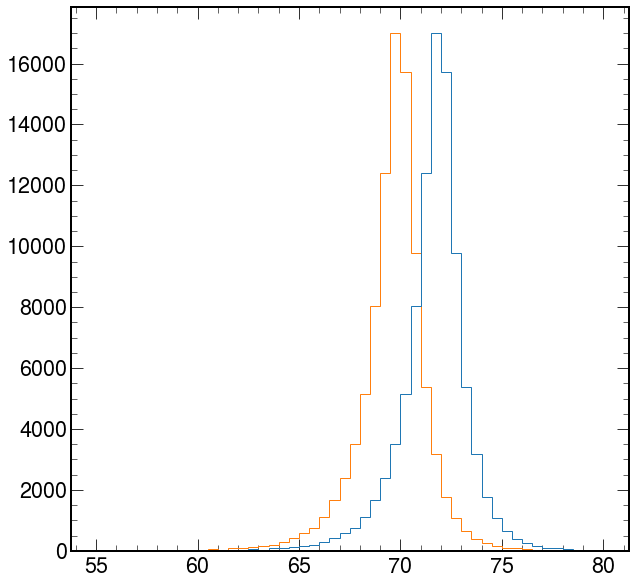

In [135]:
plt.hist([MC['ggh_M-70'].mass+2 , m_gg['ggh_M-70']], range = (55, 80) , bins = 50, histtype = 'step')
plt.show()

In [ ]:
m_gg
photon_pt[proc][:,0]/m_gg
photon_pt[proc][:,1]/m_gg
photon_cos_del_phi[proc]
photon_eta[proc][:, 0]
photon_eta[proc][:, 1]

# atleast 1 lepton
lep_pt[proc][:,0]
lep_pt[proc][:,1]
lep_eta[proc][:,0]
delta_r_lead_lead_lep[proc]
delta_r_sublead_lead_lep[proc]

# atleast 2 leptons
delta_r_lead_sublead_lep[proc]
delta_r_sublead_sublead_lep[proc]
m_ll[proc]
lepton_cos_del_phi[proc]
theta_photons_leptons[proc]

# atleast 1 jet
MC[proc].n_jets
MC[proc].jet1_pt
MC[proc].jet2_pt
MC[proc].jet1_btagDeepFlavB
MC[proc].jet2_btagDeepFlavB

In [143]:
ylim_bottom = 0
cms_label = 'Private work'
cms_year = 2022
cms_com = "13.6"
ylabel = 'Events per bin'
plot_range = [50, 125]
mc_norm = 1000

/tmp/ipykernel_516/4068613399.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=ylim_bottom)


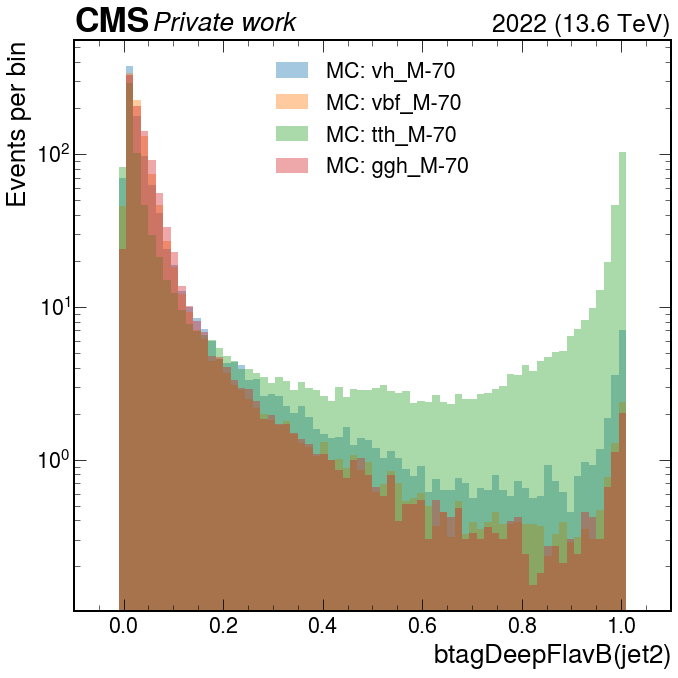

In [242]:
mc_var_combined= [MC[proc].jet2_btagDeepFlavB for proc in processes]
xlabel = r'$btagDeepFlavB(jet2)$'


plot_range = [-0.1, 1.1]
n_bins = 80
hist_range = plot_range#[0, 1.5]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning)#, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist = mc_var_hist / ak.sum(mc_var_hist)
    mc_var_hist = mc_var_hist * mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), 
                 histtype='fill', 
                 alpha = 0.4,
                 label = f"MC: {processes[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yscale('log')
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.savefig(f"{'plots'}/{'70'}_jet2_btagDeepFlavB.png")
plt.show()

### Rough

In [136]:
MC['vh_M-70'].n_jets[MC['vh_M-70'].jet1_btagDeepFlavB >-1]
# MC['vh_M-70'].electron1_mvaIso_WP90>0

<Array [2, 3, 1, 1, 2, 2, 1, 1, ..., 2, 1, 2, 2, 1, 1, 3] type='73663 * ?int64'>

In [82]:
elec

{'vh_M-70': <Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0] type='83229 * ?int64'>,
 'GluGluHtoGG_M-70': <Array [0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0] type='93217 * ?int64'>,
 'vbf_M-70': <Array [0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0] type='107298 * ?int64'>,
 'ttHtoGG_M-70': <Array [1, 0, 0, 0, 0, 0, 0, 1, ..., 0, 0, 0, 1, 0, 0, 0] type='96535 * ?int64'>}

In [23]:
ak.any(MC[proc].n_electrons, axis =-1 ) # and MC[proc].n_electrons)

True

In [28]:
ak.sum(MC[proc].n_electrons>0)

17970

In [37]:
ak.max(MC[proc].n_muons[(MC[proc].n_electrons>0) & (MC[proc].n_muons>0 )])

3

In [41]:
ak.sum((MC[proc].n_electrons==0) & (MC[proc].n_muons==0 ) & (MC[proc].n_jets>0))

63304

In [54]:
ak.sum(MC[proc].electron1_mvaIso_WP90[MC[proc].electron1_mvaIso >-1])

15671.0

In [9]:
(MC[proc].jet1_pt-MC[proc].jet2_pt)/MC[proc].jet1_pt*100

<Array [51.4, 36.4, 1.98, 4.81, ..., 44.4, 27.7, 16.5] type='96535 * ?float64'>

In [7]:
MC[proc].jet2_pt

<Array [59.5, 47.9, 217, 68.1, ..., 59.5, 142, 136] type='96535 * ?float64'>

In [68]:
ak.sum(((MC[proc].n_electrons>0) | (MC[proc].n_muons>0)) & (MC[proc].n_jets==0))

64

In [64]:
1|10

11

In [9]:
MC['vh_M-70'].n_jets

<Array [2, 3, 1, 0, 1, 2, 0, 2, ..., 2, 1, 2, 2, 1, 1, 3] type='83229 * ?int64'>

## Plots 2

#### funk

In [53]:
# Set up CMS style
plt.style.use('default')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 7

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


def create_cms_plot(data_dict, variable_name, xlabel, bins=100, xlim=None, ylim=None, log_scale=True):
    """
    Create CMS-style stacked histogram plot
    
    Parameters:
    - data_dict: Dictionary with keys as sample names and values as arrays
    - variable_name: Name for the plot title
    - xlabel: X-axis label
    - bins: Number of bins or bin edges
    - xlim: X-axis limits (min, max)
    - ylim: Y-axis limits (min, max)
    - log_scale: Whether to use log scale for y-axis
    """
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define colors for your 4 samples (adjust as needed)
    colors = {
        'vh_M-70': '#FFD700',      # Gold/Yellow
        'ggh_M-70': '#4169E1',  # Blue
        'vbf_M-70': '#32CD32',     # Green
        'tth_M-70': '#FF6347'  # Red/Orange
    }
    
    # Define labels (clean up the names)
    labels = {
        'vh_M-70': 'vh→γγ (M=70)',
        'ggh_M-70': 'ggh→γγ (M=70)',
        'vbf_M-70': 'vbf h→γγ (M=70)',
        'tth_M-70': 'tth→γγ (M=70)'
    }
    
    # Prepare data for stacking
    sample_names = list(data_dict.keys())
    sample_data = [data_dict[name] for name in sample_names]
    sample_colors = [colors.get(name, '#808080') for name in sample_names]
    sample_labels = [labels.get(name, name) for name in sample_names]
    
    # Create stacked histogram
    n, bins, patches = ax.hist(sample_data, bins=bins, stacked=True, 
                              color=sample_colors, label=sample_labels,
                              alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Set log scale if requested
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(bottom=0.1)
    
    # Set limits
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    # Labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Events/(bin width)')
    
    # Add CMS preliminary label
    ax.text(0.02, 0.98, 'CMS Preliminary', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', verticalalignment='top')
    
    # Add luminosity info (adjust as needed)
    ax.text(0.5, 0.98, '13.6TeV', transform=ax.transAxes, 
            fontsize=12, horizontalalignment='right', verticalalignment='top')
    
    # Legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3)
    
    # Tight layout
    plt.tight_layout()
    
    return fig, ax

# Example usage:
def example_plots():
    # Generate some example data (replace with your actual data)
    np.random.seed(42)
    
    # Example 1: Pt(lepton1)
    pt_data = {
        'vh_M-70': np.random.exponential(30, 1000) + 10,
        'ggh_M-70': np.random.exponential(25, 1500) + 10,
        'vbf_M-70': np.random.exponential(35, 800) + 10,
        'tth_M-70': np.random.exponential(20, 600) + 10
    }
    
    fig1, ax1 = create_cms_plot(pt_data, 'Pt(l1)', 'Pt (lepton1) [GeV]', 
                               bins=np.linspace(0, 150, 30), xlim=(0, 150))
    plt.show()
    
    # Example 2: Eta(lepton1)
    eta_data = {
        'vh_M-70': np.random.normal(0, 1.2, 1000),
        'ggh_M-70': np.random.normal(0, 1.0, 1500),
        'vbf_M-70': np.random.normal(0, 1.1, 800),
        'tth_M-70': np.random.normal(0, 0.9, 600)
    }
    
    fig2, ax2 = create_cms_plot(eta_data, 'η(l1)', 'η(lepton1)', 
                               bins=np.linspace(-3, 3, 25), xlim=(-3, 3))
    plt.show()

# Function to create multiple plots in a grid (like your image)
def create_plot_grid(data_dict_list, titles, xlabels, bins_list=None, xlims=None):
    """
    Create a grid of CMS-style plots
    
    Parameters:
    - data_dict_list: List of data dictionaries for each plot
    - titles: List of plot titles
    - xlabels: List of x-axis labels
    - bins_list: List of bin specifications for each plot
    - xlims: List of x-axis limits for each plot
    """
    
    n_plots = len(data_dict_list)
    n_cols = 3  # Adjust based on your preference
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes]
    axes = axes.flatten()
    
    for i, (data_dict, title, xlabel) in enumerate(zip(data_dict_list, titles, xlabels)):
        ax = axes[i]
        
        # Use provided bins or default
        bins = bins_list[i] if bins_list else 80
        xlim = xlims[i] if xlims else None
        
        # Create individual plot on this axis
        create_cms_plot_on_axis(ax, data_dict, title, xlabel, bins, xlim)
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig, axes

def create_cms_plot_on_axis(ax, data_dict, title, xlabel, bins=50, xlim=None):
    """Helper function to create plot on existing axis"""
    
    # Same color and label setup as before
    colors = {
        'vh_M-70': '#FFD700',
        'ggh_M-70': '#4169E1',
        'vbf_M-70': '#32CD32',
        'tth_M-70': '#FF6347'
    }
    
    labels = {
        'vh_M-70': 'vh→γγ (M=70)',
        'ggh_M-70': 'ggh→γγ (M=70)',
        'vbf_M-70': 'vbf h→γγ (M=70)',
        'tth_M-70': 'tth→γγ (M=70)'
    }
    
    sample_names = list(data_dict.keys())
    sample_data = [data_dict[name] for name in sample_names]
    sample_colors = [colors.get(name, '#808080') for name in sample_names]
    sample_labels = [labels.get(name, name) for name in sample_names]
    
    # Create histogram
    ax.hist(sample_data, bins=bins, stacked=True, 
            color=sample_colors, label=sample_labels,
            alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.1)
    
    if xlim:
        ax.set_xlim(xlim)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Events/(bin width)')
    ax.set_title(title)
    
    # Add CMS label
    ax.text(0.02, 0.98, 'CMS Preliminary', transform=ax.transAxes, 
            fontsize=10, fontweight='bold', verticalalignment='top')
    
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Uncomment to run examples
# example_plots()

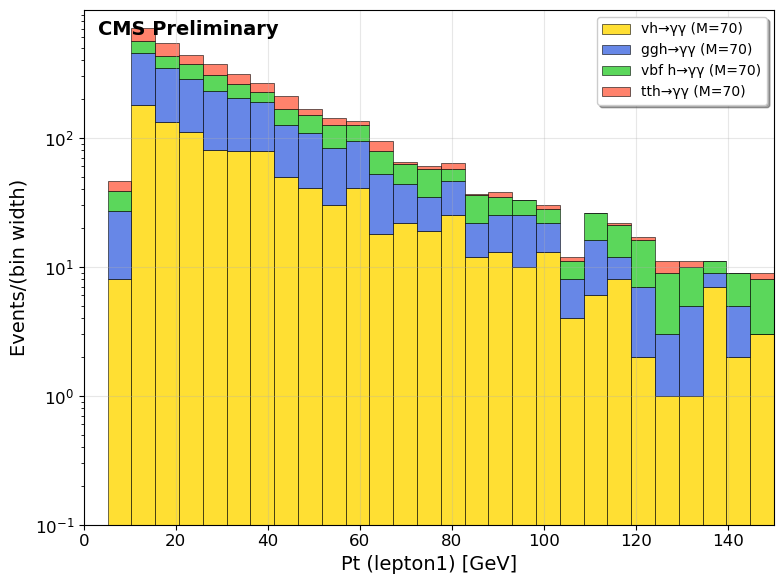

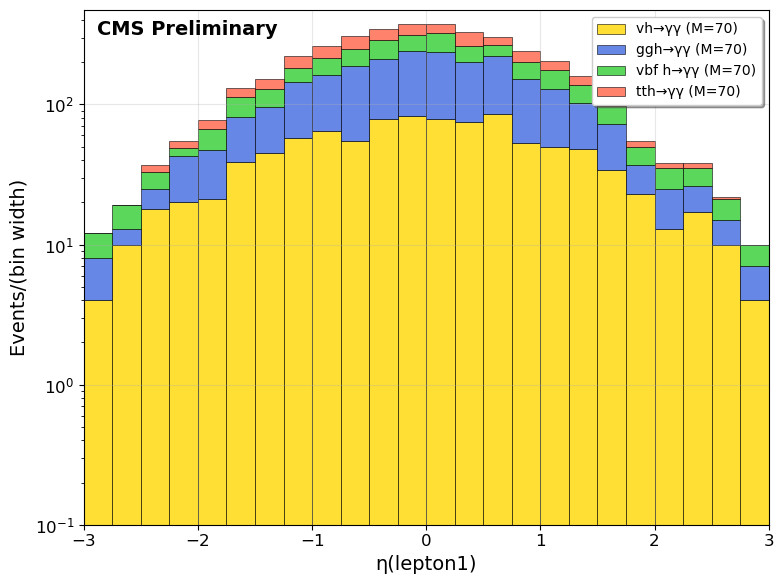

In [23]:
example_plots()

#### stuff

In [30]:
mc_var_combined= [extract_variable(MC[f'{proc}'], 'lead_pt') for proc in processes]

#### Pt/M

In [68]:

# pt_lead_by_m, pt_sublead_by_m = {}, {}
# lead_eta, sublead_eta = {}, {}
# # cos_phi_gg = {}
# # pt_lead_lep, pt_sublead_lep = {}, {}
# # eta_lead_lep, eta_sublead_lep = {}, {}
# # delta_r_lead_lead_lep , delta_r_lead_sublead_lep = {}, {}
# # delta_r_sublead_lead_lep , delta_r_sublead_sublead_lep = {}, {}
# Njet , pt_lead_jet, btagDeepFlavB_lead_jet = {}, {}, {}

for proc in processes:
    # pt_lead_by_m[f'{proc}'] = MC[f'{proc}'].lead_pt/MC[f'{proc}'].mass
    # pt_sublead_by_m[f'{proc}'] = MC[f'{proc}'].sublead_pt/MC[f'{proc}'].mass

    # lead_eta[f'{proc}'] = MC[f'{proc}'].lead_eta
    # sublead_eta[f'{proc}'] = MC[f'{proc}'].sublead_eta

    # # cos_phi_gg[f'{proc}'] = np.cos(MC[f'{proc}'].sublead_phi - MC[f'{proc}'].lead_phi)

    # Njet[f'{proc}'] = MC[f'{proc}'].n_jets
    # pt_lead_jet[f'{proc}'] = MC[f'{proc}'].jet1_pt
    btagDeepFlavB_lead_jet[f'{proc}'] = MC[f'{proc}'].jet1_btagDeepFlavB[MC[f'{proc}'].jet1_btagDeepFlavB>-1]
    
    
# fig1, ax1 = create_cms_plot(var_data, 'Pt(l1)', 'Pt (lepton1) [GeV]', 
#                            bins=np.linspace(0, 150, 30), xlim=(0, 150))
# plt.show()

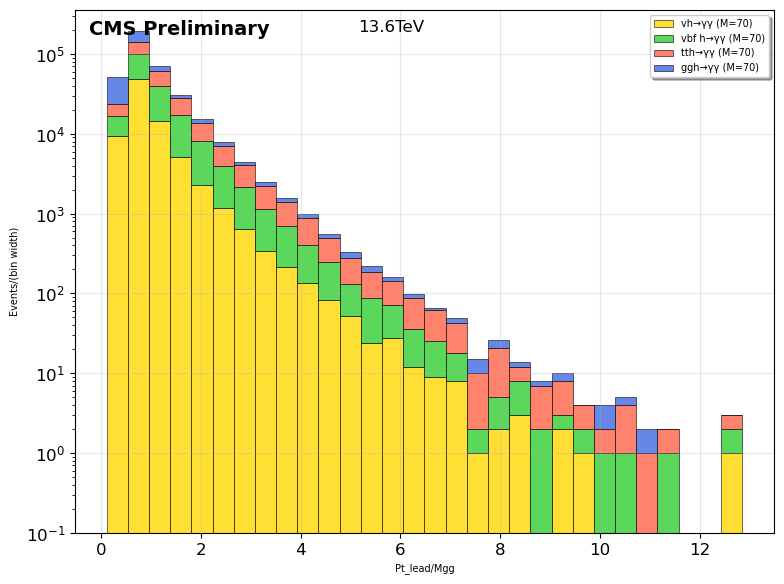

In [60]:
fig, ax = create_cms_plot(pt_lead_by_m, 'Pt_lead/Mgg', 'Pt_lead/Mgg', 30)

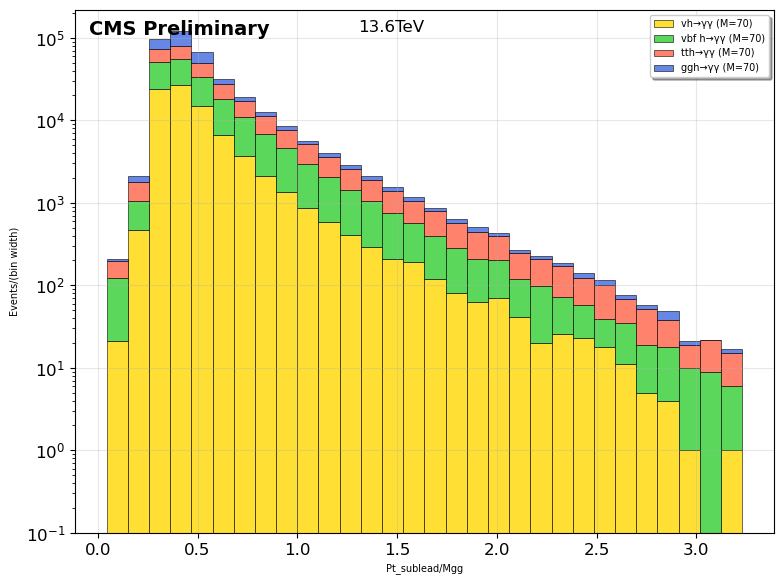

In [61]:
fig, ax = create_cms_plot(pt_sublead_by_m, 'Pt_sublead/Mgg', 'Pt_sublead/Mgg', 30)

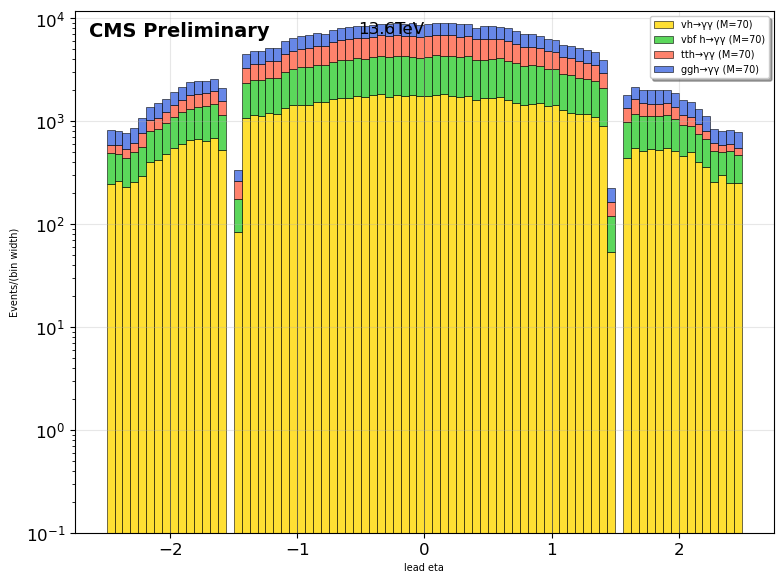

In [62]:
fig, ax = create_cms_plot(lead_eta, 'lead eta', 'lead eta', 80, )

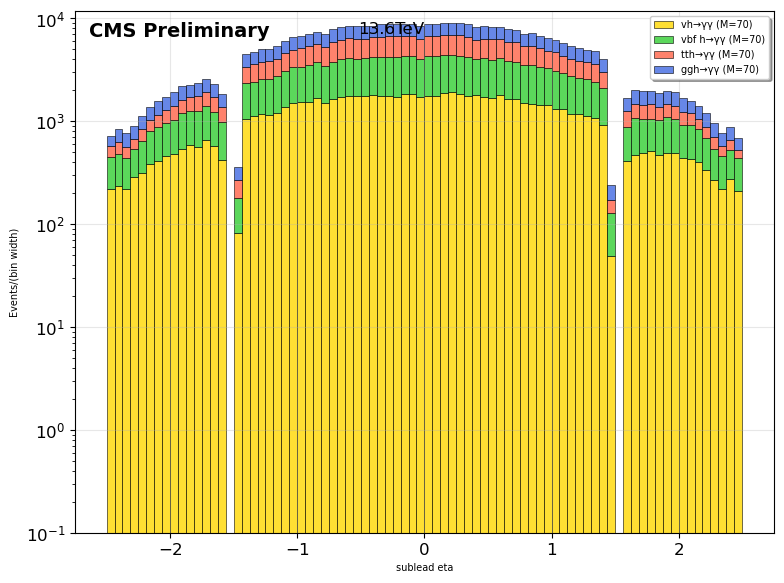

In [63]:
fig, ax = create_cms_plot(sublead_eta, 'sublead eta', 'sublead eta', 80 )

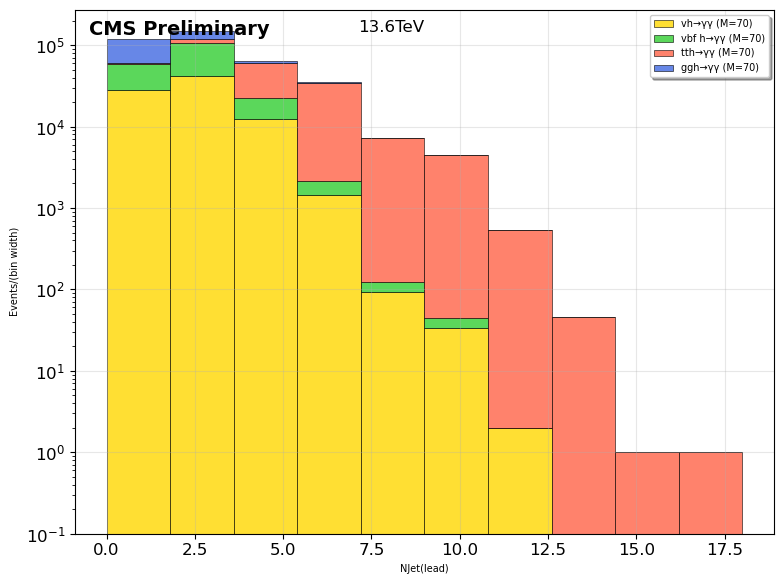

In [65]:
fig, ax = create_cms_plot(Njet, 'NJet', 'NJet(lead)', 10 )

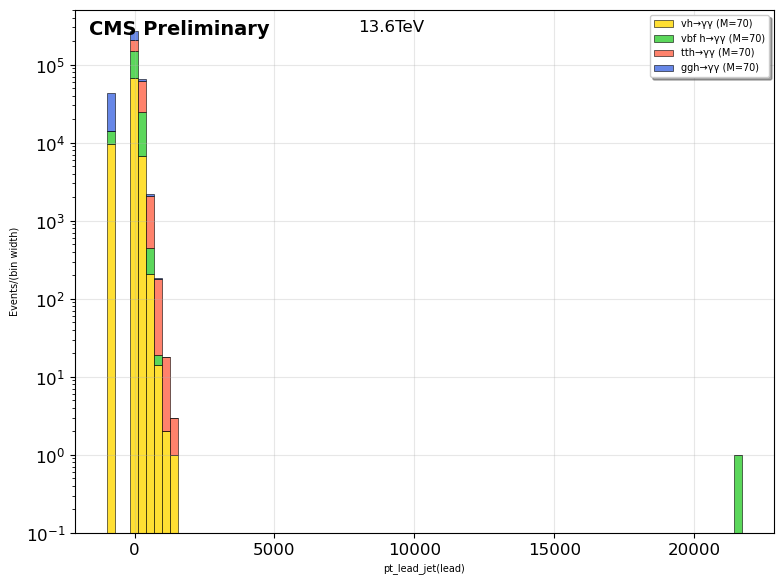

In [66]:
fig, ax = create_cms_plot(pt_lead_jet, 'pt_lead_jet', 'pt_lead_jet(lead)', 80 )

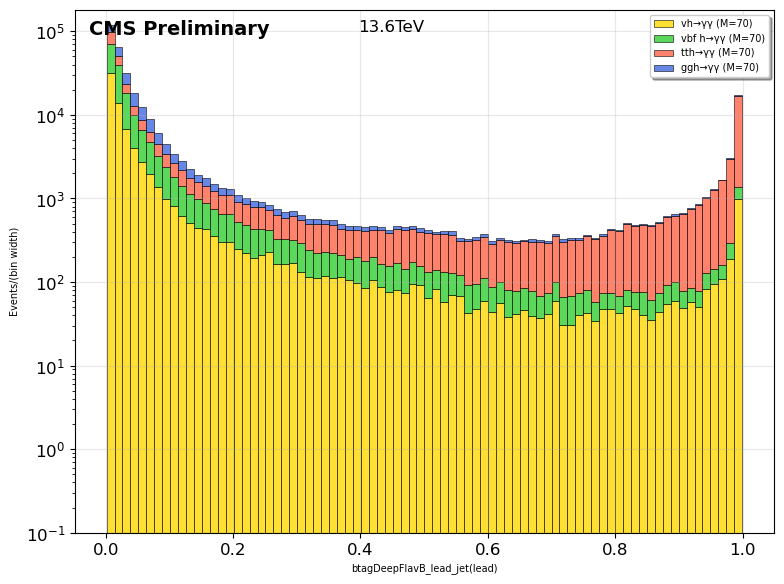

In [69]:
fig, ax = create_cms_plot(btagDeepFlavB_lead_jet, 'btagDeepFlavB_lead_jet', 'btagDeepFlavB_lead_jet(lead)', 80 )

AttributeError: 'list' object has no attribute 'flatten'

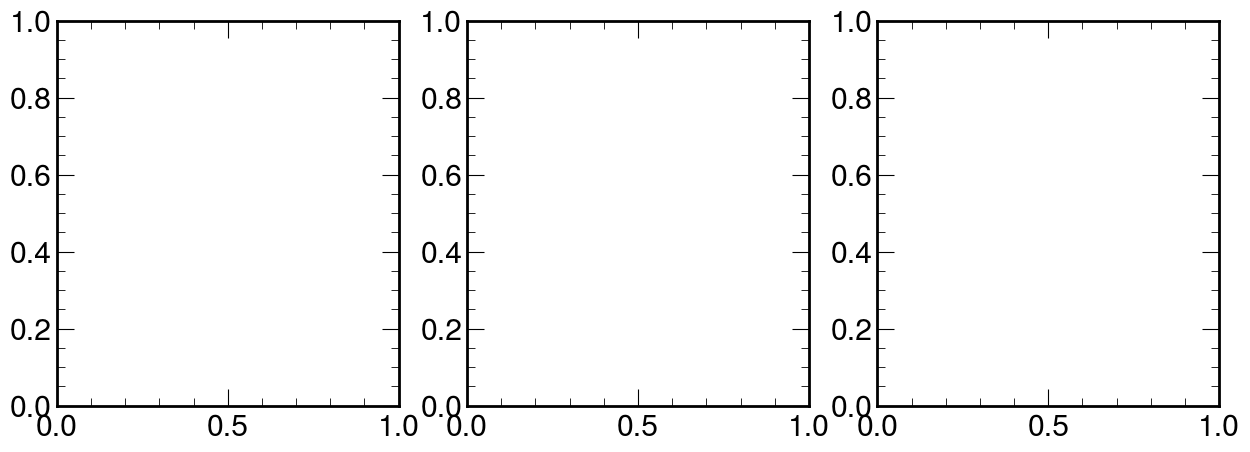

In [41]:
data_list = [var_data, var_data2]  # Your different variables
titles = ['Pt(l1)', 'η(l1)']
xlabels = ['Pt (lepton1) [GeV]', 'η(lepton1)']

fig, axes = create_plot_grid(data_list, titles, xlabels)

In [ ]:
Pt(gamma)/Mgg
Cos(delta phi) (gg)

In [31]:
mc_var_combined

[array([ 42.49447 ,  43.750877, 117.26955 , ...,  57.64546 ,  62.244873,
        111.101265], dtype=float32),
 array([ 66.030205,  41.951256, 153.10223 , ...,  62.750263,  48.75145 ,
         65.420364], dtype=float32),
 array([ 55.00418 , 103.82009 ,  59.307735, ..., 184.38535 ,  47.97319 ,
        127.01326 ], dtype=float32),
 array([32.220837, 65.71103 , 36.095165, ..., 42.420036, 33.36859 ,
        93.06014 ], dtype=float32)]

In [ ]:




your_data = {
    'vh_M-70': your_vh_array,
    'GluGluHtoGG_M-70': your_ggh_array,
    'vbf_M-70': your_vbf_array,
    'ttHtoGG_M-70': your_tth_array
}

# Create a single plot
fig, ax = create_cms_plot(your_data, 'Pt(l1)', 'Pt (lepton1) [GeV]', 
                         bins=np.linspace(0, 150, 30))

# Or create multiple plots in a grid
data_list = [pt_data, eta_data, phi_data]  # Your different variables
titles = ['Pt(l1)', 'η(l1)', 'φ(l1)']
xlabels = ['Pt (lepton1) [GeV]', 'η(lepton1)', 'φ(lepton1)']

fig, axes = create_plot_grid(data_list, titles, xlabels)

In [17]:
ylim_bottom = 0
cms_label = 'CMS Preliminary'
cms_year = 2024
cms_com = "13.6"
ylabel = 'Events per bin'
plot_range = [50, 125]
mc_norm = 1000

IndexError: list index out of range

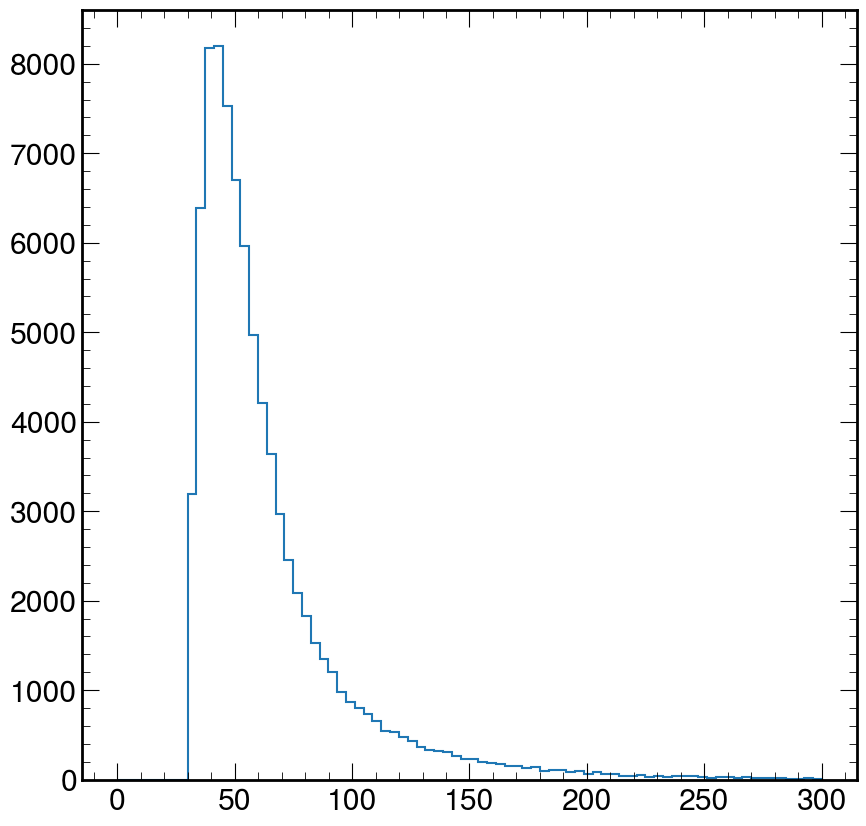

In [32]:
# mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'lead_pt') for mass in masses]


xlabel = 'lead_pt'
plot_range = [-0.1, 300]
n_bins = 80
hist_range = plot_range#[0, 1.5]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning)#, weights=mc_weights[i])

    # Normalize MC histogram
    # mc_var_hist /= np.sum(mc_var_hist)
    # mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]} lead")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.yscale('log')
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
# plt.savefig(f"{'plots'}/{'70'}_pt_m_nonnormalised.png")
plt.show()

## Unmerged

In [9]:
# masses = ['70']#, '75', '80', '85', '90', '95', '100', '105', '110']#['60', '90', '95', '105', '110']
# input_dir_0 = 'Corrections_OFF/NTuples1'

# MC_dict_0 = load_mc_samples(masses, input_dir_0)
# print(f"INFO: Loaded MC samples for processes: {masses}")
bkg_samples = ['GJet_PT-40_postEE', 'DYto2L-2Jets_MLL-50_postEE']#, 'DiPhoton2Jets_postEE' , 'DYto2L-2Jets_MLL-50_postEE' , 'GJet_PT-40_postEE'  , 'qcd_PT-30to40_postEE'  , 'ZG2JtoG2L2J_postEE' , 'ZZ_postEE' , 'WZ_postEE', 'WW_postEE', 'WGto2QG_postEE']# , '']
# 'vbf_70_arr', 'vbf_80_arr',
MC_bkg_dict = {}
for smp in bkg_samples:
    MC_bkg_dict[smp] = load_data(f'NTuples/merged/' + smp ) #'/nominal'
# MC_bkg_dict[f'DYJetstoLL_50_arr'] = load_data(f'NTuples/DYJetstoLL_M-50_postEE/nominal')
# MC_bkg_dict[f'DYto2L2Jets_50_arr'] = load_data(f'NTuples/DYto2L-2Jets_MLL-50_postEE/nominal')


In [15]:
masses = ['70']#, '75', '80', '85', '90', '95', '100', '105', '110']#['60', '90', '95', '105', '110']
input_dir = 'NTuples'

MC_dict = load_mc_samples(masses, input_dir)
print(f"INFO: Loaded MC samples for processes: {masses}")

INFO: Loaded MC samples for processes: ['70']


In [16]:
MC_dict['70_arr'].fields

['pt',
 'eta',
 'phi',
 'mass',
 'charge',
 'rapidity',
 'jet1_pt',
 'jet1_eta',
 'jet1_phi',
 'jet1_mass',
 'jet1_charge',
 'jet1_btagPNetB',
 'jet1_btagDeepFlavB',
 'jet1_btagDeepFlav_CvB',
 'jet1_btagDeepFlav_CvL',
 'jet1_btagDeepFlav_QG',
 'jet1_neHEF',
 'jet1_neEmEF',
 'jet1_muEF',
 'jet1_chEmEF',
 'jet1_jetId',
 'jet1_chMultiplicity',
 'jet1_neMultiplicity',
 'jet1_chHEF',
 'jet2_pt',
 'jet2_eta',
 'jet2_phi',
 'jet2_mass',
 'jet2_charge',
 'jet2_btagPNetB',
 'jet2_btagDeepFlavB',
 'jet2_btagDeepFlav_CvB',
 'jet2_btagDeepFlav_CvL',
 'jet2_btagDeepFlav_QG',
 'jet2_neHEF',
 'jet2_neEmEF',
 'jet2_muEF',
 'jet2_chEmEF',
 'jet2_jetId',
 'jet2_chMultiplicity',
 'jet2_neMultiplicity',
 'jet2_chHEF',
 'jet3_pt',
 'jet3_eta',
 'jet3_phi',
 'jet3_mass',
 'jet3_charge',
 'jet3_btagPNetB',
 'jet3_btagDeepFlavB',
 'jet3_btagDeepFlav_CvB',
 'jet3_btagDeepFlav_CvL',
 'jet3_btagDeepFlav_QG',
 'jet3_neHEF',
 'jet3_neEmEF',
 'jet3_muEF',
 'jet3_chEmEF',
 'jet3_jetId',
 'jet3_chMultiplicity',
 'jet

In [76]:
ak.len(MC_dict['70_arr'].pt))

SyntaxError: unmatched ')' (1540086146.py, line 1)

In [77]:
MC_dict['70_arr'].pt

<Array [71.6, 31.3, 151, 71.8, ..., 97.1, 54.5, 137] type='83229 * ?float32'>

In [9]:
ak.sum(MC_dict['70_arr'].weight)

3341197.8

In [53]:
test = MC_dict['70_arr'].jet1_jetId[MC_dict['70_arr'].jet1_jetId != -999]
testn = test[test != 6]
testn[testn != 0]

<Array [2, 2, 2] type='3 * ?float64'>

In [24]:
ak.where(MC_dict['70_arr'].electron1_mvaIso_WP90 != -999)

(<Array [36, 40, 78, 100, ..., 83123, 83204, 83219, 83221] type='6455 * int64'>,)

In [33]:
MC_dict['70_arr'].electron1_mvaIso_WP90[MC_dict['70_arr'].electron1_mvaIso_WP90 == 1]  # 685, 5770   1246 , 5209

<Array [1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1] type='5770 * ?float64'>

In [14]:
cross_sections = {'vh': (1.457 + 0.9439)}

In [15]:
mc_weights = []
for mass in masses:
    weight = np.asarray(MC_dict[f'{mass}_arr'].weight) * cross_sections['vh'] #process
    mc_weights.append(weight)
# mc_weights_combined = np.concatenate(mc_weights)

In [10]:
mc_weights_bkg = []
for sample in bkg_samples:
    weight_0 = np.asarray(MC_bkg_dict[sample].weight) * cross_sections['vh'] #process
    mc_weights_bkg.append(weight_0)
# mc_weights_combined = np.concatenate(mc_weights)

In [6]:
# MC_bkg_dict['DYJetstoLL_50_arr']
# MC_bkg_dict[f'DiPhoton2Jets_postEE']

# Plots

In [20]:
ylim_bottom = 0
cms_label = 'Private work'
cms_year = 2025
cms_com = "13.6"
ylabel = 'Events per bin'
plot_range = [50, 125]
mc_norm = 1000

In [11]:
# MC_dict['70_arr']['nPV']
mc_weights_0

NameError: name 'mc_weights_0' is not defined

## nPV & GridRho

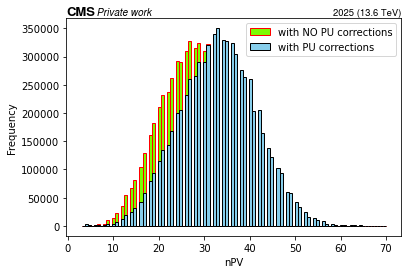

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np

# Generate random data for the histogram

# Plotting a basic histogram
plt.hist(MC_dict_0['70_arr']['nPV'], bins=100, color='lawngreen', edgecolor='red', weights = mc_weights_0, label = 'with NO PU corrections')
plt.hist(MC_dict['70_arr']['nPV'], bins=100, color='skyblue', edgecolor='black', weights = mc_weights, label = 'with PU corrections')


# Adding labels and title
plt.xlabel('nPV')
plt.ylabel('Frequency')
# plt.title('Basic Histogram')

hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)

# Display the plot
plt.legend()
plt.show()

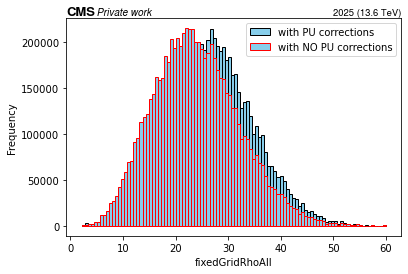

In [18]:
# Plotting a basic histogram
plt.hist(MC_dict['70_arr']['fixedGridRhoAll'], bins=100, color='skyblue', edgecolor='black', weights = mc_weights, label = 'with PU corrections')
plt.hist(MC_dict_0['70_arr']['fixedGridRhoAll'], bins=100, color='skyblue', edgecolor='red', weights = mc_weights_0, label = 'with NO PU corrections')

# Adding labels and title
plt.xlabel('fixedGridRhoAll')
plt.ylabel('Frequency')
# plt.title('Basic Histogram')

hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)

# Display the plot
plt.legend()
plt.show()


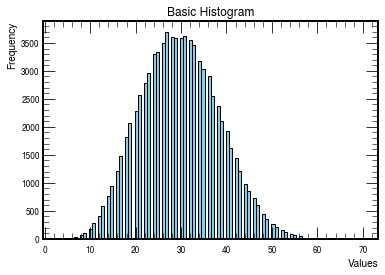

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data for the histogram

# Plotting a basic histogram
plt.hist(MC_dict_0['70_arr']['nPV'], bins=100, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Basic Histogram')

# Display the plot
plt.show()


/tmp/ipykernel_573/569965317.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)


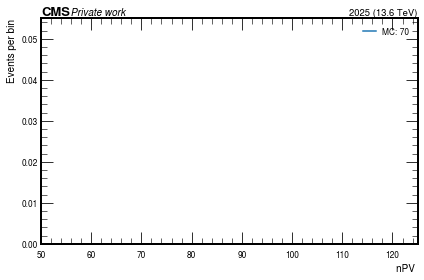

In [11]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'nPV') for mass in masses]

xlabel = 'nPV '

n_bins = 100
hist_range = [0, 200]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
# plt.savefig(f"{'plots'}/{'all_mass'}_plot_nonnormalised.pdf")
plt.show()

## R9

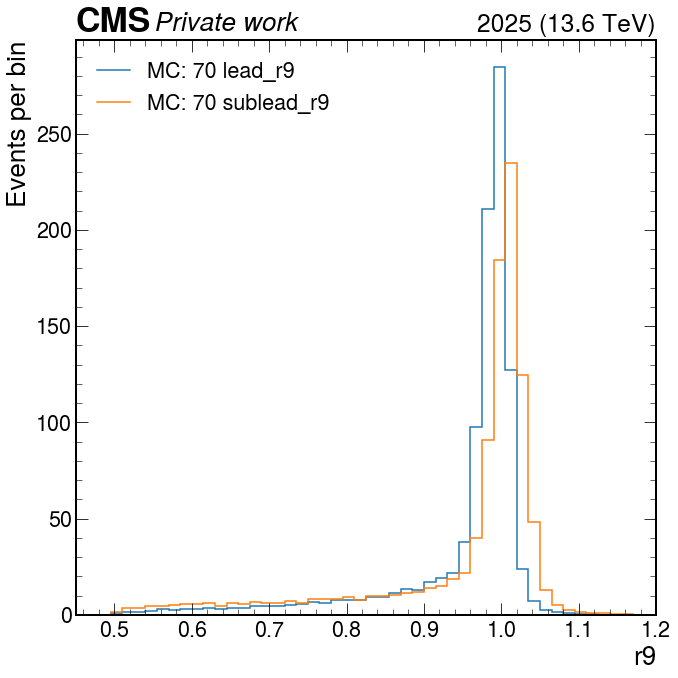

In [24]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'lead_r9') for mass in masses]

xlabel = 'r9'
plot_range = [0.45, 1.2]
n_bins = 50
hist_range = plot_range#[0, 1.5]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]} lead_r9")


mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'sublead_r9') for mass in masses]
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]} sublead_r9")


plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.savefig(f"{'plots'}/{'70'}_r9_nonnormalised.png")
plt.show()

## Rapidity

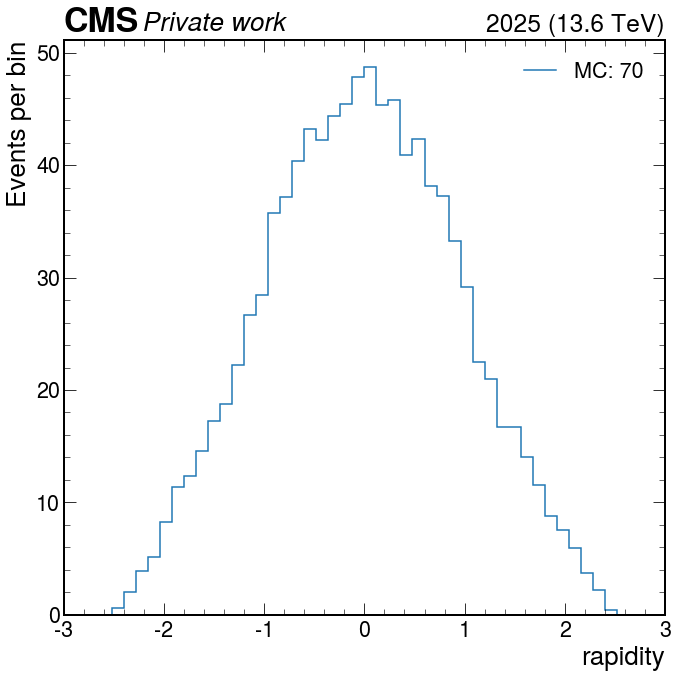

In [27]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'rapidity') for mass in masses]

xlabel = 'rapidity'
plot_range = [-3, 3]
n_bins = 50
hist_range = plot_range#[0, 1.5]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")


plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.savefig(f"{'plots'}/{'70'}_rapidity_nonnormalised.png")
plt.show()

## Pt/m

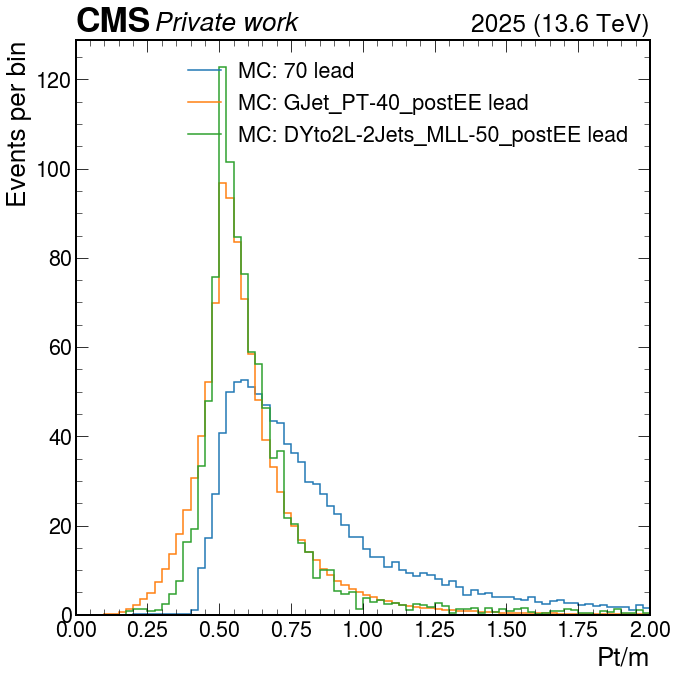

In [11]:
#lead
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'lead_pt')/extract_variable(MC_dict[f'{mass}_arr'], 'mass') for mass in masses]
mc_var_combined_bkg= [extract_variable(MC_bkg_dict[sample], 'lead_pt')/extract_variable(MC_bkg_dict[sample], 'mass') for sample in bkg_samples]
#sublead
# mc_var_combined2= [extract_variable(MC_dict[f'{mass}_arr'], 'sublead_pt')/extract_variable(MC_dict[f'{mass}_arr'], 'mass') for mass in masses]
# mc_var_combined_bkg2= [extract_variable(MC_bkg_dict[sample], 'sublead_pt')/extract_variable(MC_bkg_dict[sample], 'mass') for sample in bkg_samples]

xlabel = 'Pt/m'
plot_range = [0, 2]
n_bins = 80
hist_range = plot_range#[0, 1.5]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]} lead")

    # mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined2[i], binning, weights=mc_weights[i])

    # # Normalize MC histogram
    # mc_var_hist /= np.sum(mc_var_hist)
    # mc_var_hist *= mc_norm

    # # Plot the variable
    # hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]} sublead")

for i in range(len(mc_var_combined_bkg[:])):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined_bkg[i], binning, weights=mc_weights_bkg[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {bkg_samples[i]} lead")


plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.yscale('log')
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
# plt.savefig(f"{'plots'}/{'70'}_pt_m_nonnormalised.png")
plt.show()

In [ ]:
0.33 , 0.25

## lead_electronIdx

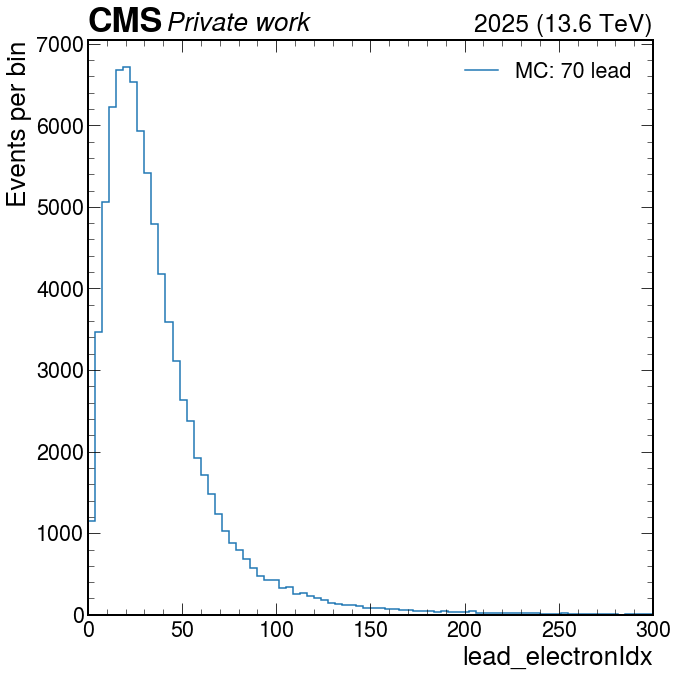

In [30]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'PuppiMET_pt') for mass in masses]


xlabel = 'lead_electronIdx'
plot_range = [-0.1, 300]
n_bins = 80
hist_range = plot_range#[0, 1.5]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning)#, weights=mc_weights[i])

    # Normalize MC histogram
    # mc_var_hist /= np.sum(mc_var_hist)
    # mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]} lead")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.yscale('log')
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
# plt.savefig(f"{'plots'}/{'70'}_pt_m_nonnormalised.png")
plt.show()

## Mass

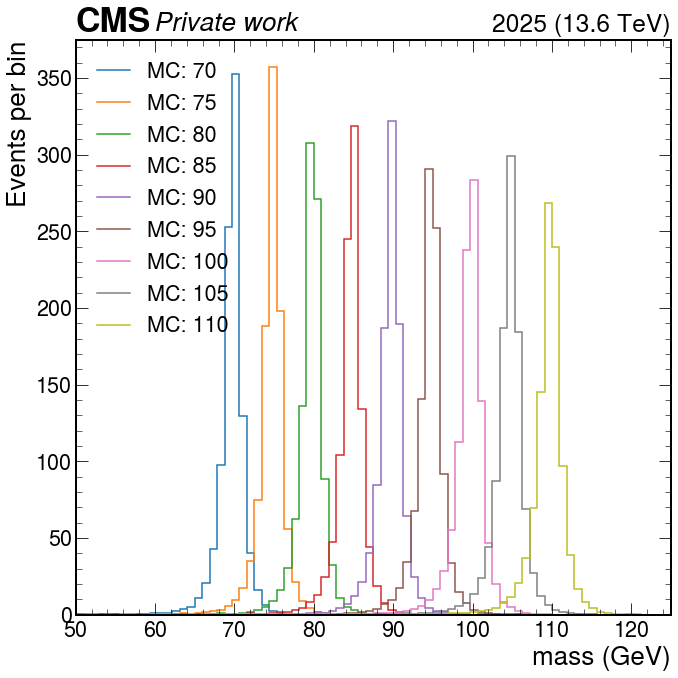

In [8]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'mass') for mass in masses]

xlabel = 'mass (GeV)'

n_bins = 80
hist_range = [50, 125]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
# plt.savefig(f"{'plots'}/{'all_mass'}_plot_nonnormalised.pdf")
plt.show()

/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_var_hist)
/tmp/ipykernel_475/2591342320.py:14: RuntimeWarning: invalid value encountered in divide
  mc_var_hist /= np.sum(mc_va

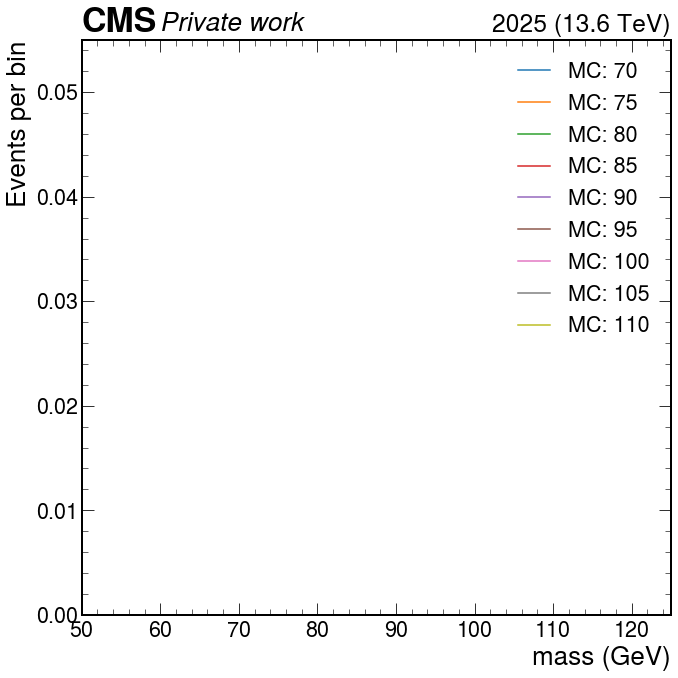

In [17]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'mass') for mass in masses]

xlabel = 'mass (GeV)'

n_bins = 80
hist_range = [50, 125]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
# plt.savefig(f"{'plots'}/{'all_mass'}_plot_nonnormalised.pdf")
plt.show()

## Something

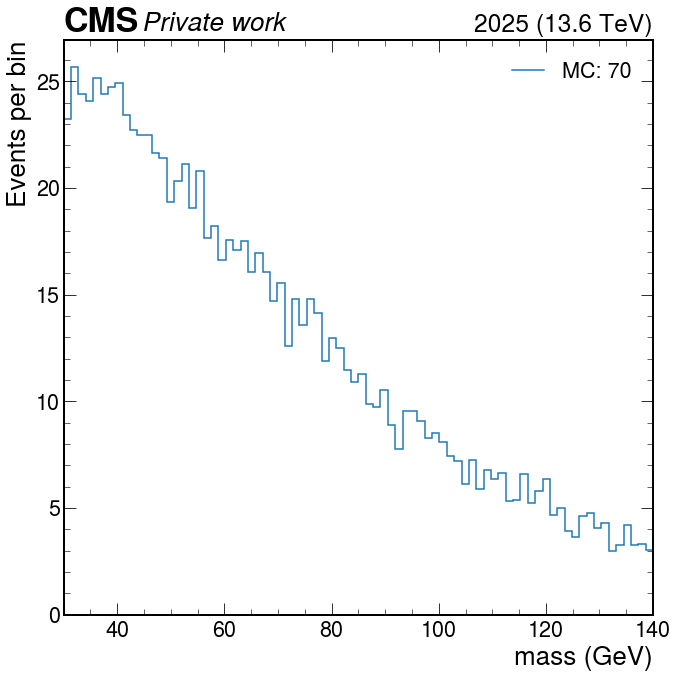

In [14]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'pt') for mass in masses]

xlabel = 'mass (GeV)'
plot_range = [30, 140]
n_bins = 80
hist_range = [30, 140]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.show()

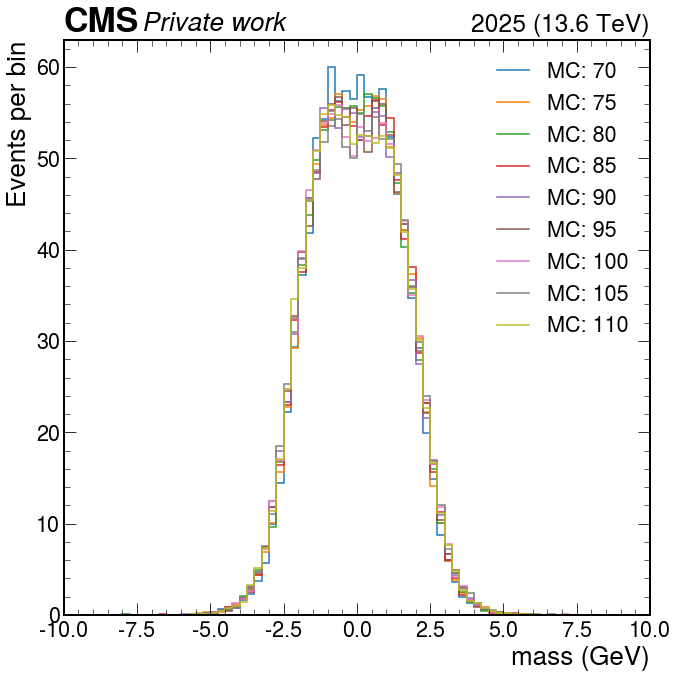

In [26]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'eta') for mass in masses]

xlabel = 'mass (GeV)'
plot_range = [-10, 10]
n_bins = 80
hist_range = [-10, 10]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.show()

In [17]:
# MC_dict['70_arr']

<Array [{pt: 71.6, eta: -1.43, ...}, ...] type='83229 * {pt: ?float32, eta:...'>

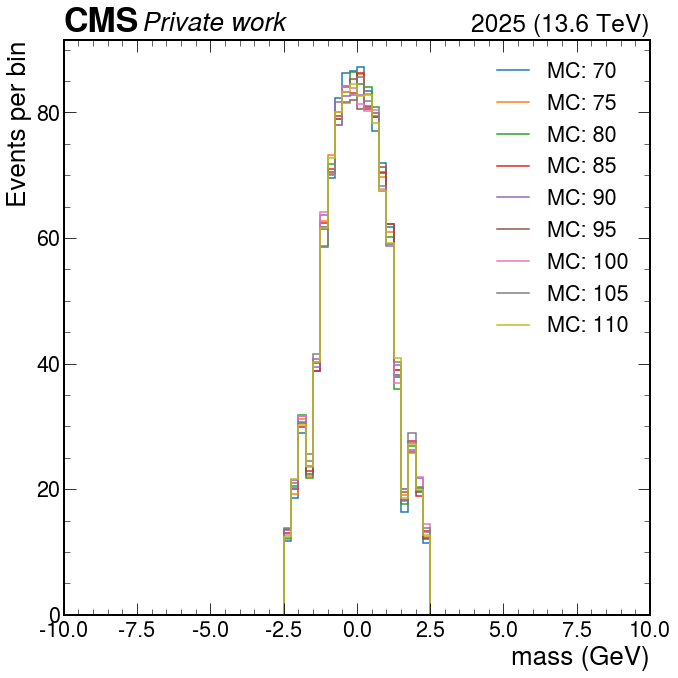

In [28]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'lead_eta') for mass in masses]

xlabel = 'mass (GeV)'
plot_range = [-10, 10]
n_bins = 80
hist_range = [-10, 10]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.show()

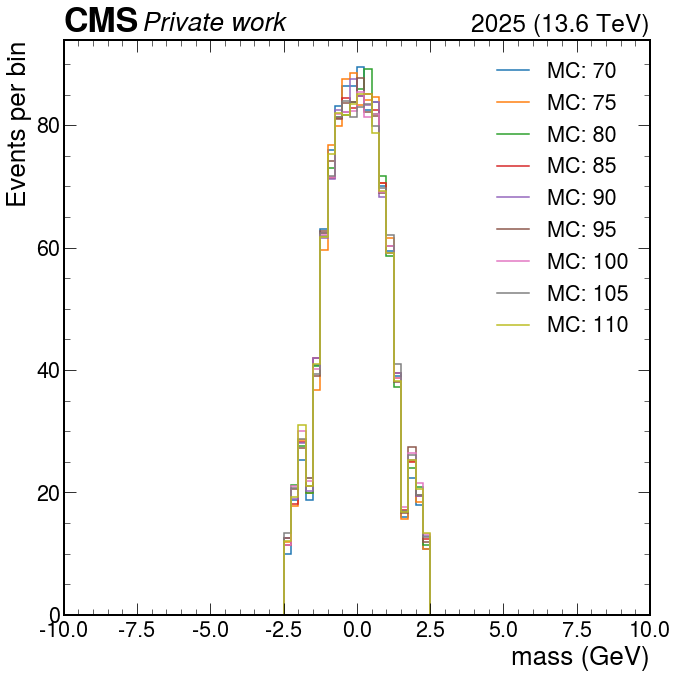

In [29]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'sublead_eta') for mass in masses]

xlabel = 'mass (GeV)'
plot_range = [-10, 10]
n_bins = 80
hist_range = [-10, 10]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.show()

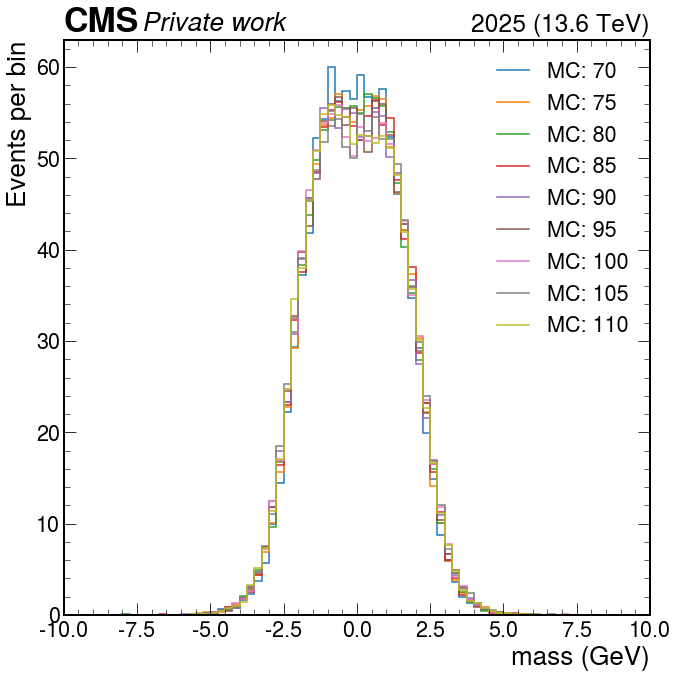

In [19]:
mc_var_combined= [extract_variable(MC_dict[f'{mass}_arr'], 'eta') for mass in masses]

xlabel = 'mass (GeV)'
plot_range = [-10, 10]
n_bins = 80
hist_range = [-10, 10]
binning, width, center = compute_binning(n_bins, hist_range[0], hist_range[1])

plt.style.use(hep.style.CMS)
for i in range(len(mc_var_combined)):
    mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])

    # Normalize MC histogram
    mc_var_hist /= np.sum(mc_var_hist)
    mc_var_hist *= mc_norm

    # Plot the variable
    hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    # plt.hist((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.xlim(plot_range)
plt.ylim(bottom=ylim_bottom)
hep.cms.label(cms_label, data=True, year=cms_year, com=cms_com)
plt.tight_layout()
plt.show()

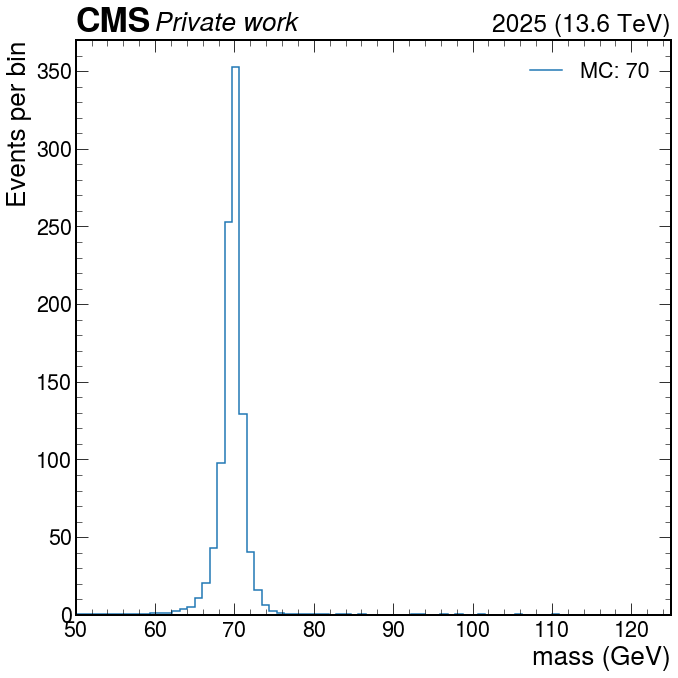

In [17]:

# plt.clf()

In [16]:
plt.plot(mc_var_hist)
plt.show()

NameError: name 'mc_var_hist' is not defined

In [6]:
config_file = "./configs/plot_settings.json"

config = load_config(config_file)
print(f"INFO: Loaded configuration from {config_file}")

INFO: Loaded configuration from ./configs/plot_settings.json


In [7]:
plots_dir = 'plots'

In [17]:
for var_config in config['variables']:
    var_name = var_config['name']
    # Extract the variable for each mass and combine them
    mc_var_combined = [extract_variable(MC_dict[f'{mass}_arr'], var_name) for mass in masses]

    # Compute binning
    binning, width, center = compute_binning(var_config['n_bins'], var_config['hist_range'][0], var_config['hist_range'][1])

    plt.style.use(hep.style.CMS)

    for i in range(len(mc_var_combined)):
        mc_var_hist, mc_var_edges = compute_histogram(mc_var_combined[i], binning, weights=mc_weights[i])
    
        # Normalize MC histogram
        # mc_var_hist /= np.sum(mc_var_hist)
        # mc_var_hist *= var_config['mc_norm']
    
        # Plot the variable
        hep.histplot((mc_var_hist, mc_var_edges), histtype='step', label = f"MC: {masses[i]}")
    
    plt.xlabel(var_config['xlabel'])
    plt.ylabel(var_config['ylabel'])
    if config['plot_settings']['legend']:
        plt.legend()
    plt.xlim(var_config['plot_range'])
    plt.ylim(bottom=config['plot_settings']['ylim_bottom'])
    hep.cms.label(config['plot_settings']['cms_label'], data=True, year=config['plot_settings']['cms_year'], com=config['plot_settings']['cms_com'])
    plt.tight_layout()
    sanitized_var_name = sanitize_filename(var_config['name'])
    # plt.savefig(f"{plots_dir}/{sanitized_var_name}_plot.pdf")
    plt.show()
    plt.clf()

ValueError: weights should have the same shape as a.

## 

In [3]:
def load_data(file_path):
    return ak.from_parquet(file_path)

def load_mc_samples_new(processes, base_path):
    MC_dict = {}
    for process in processes:
        MC_dict[f'{process}_arr'] = load_data(f'{base_path}/vh_M-{process}_preEE')
    return MC_dict

In [4]:
masses = ['60', '90', '95', '105', '110']
input_dir = 'NTuples/merged'

MC_dict = load_mc_samples_new(masses, input_dir)
print(f"INFO: Loaded MC samples for processes: {masses}")

INFO: Loaded MC samples for processes: ['60', '90', '95', '105', '110']


In [5]:
MC_dict['60_arr']

<Array [{lead_seediEtaOriX: 61, ...}, ...] type='4716 * {lead_seediEtaOriX:...'>

In [6]:
MC_dict['60_arr'].GenPTH

<Array [138, 33.5, 94.5, -999, ..., 118, 184, 183, -999] type='4716 * ?float64'>